1. Градиентный спуск и его модификации
   - Выбрать [тестовые функции оптимизации](https://ru.wikipedia.org/wiki/Тестовые_функции_для_оптимизации) (2 шт)
   - Запрограммировать собственнуб реализацию классического градиентного спуска
   - Запрограммировать пайлайн тестирования алгоритма оптимизации
     - Визуализации функции и точки оптимума
     - Вычисление погрешности найденного решения в сравнение с аналитическим для нескольких запусков
     - Визуализации точки найденного решения (можно добавить анимацию на плюс балл)
   - Запрограммировать метод вычисления градиента
     - Передача функции градиента от пользователя
     - Символьное вычисление градиента (например с помощью [sympy](https://www.sympy.org/en/index.html)) (на доп балл)
     - Численная аппроксимация градиента (на доп балл)
   - Запрограммировать одну моментную модификацию и протестировать ее
   - Запрограммировать одну адаптивную модификацию и протестировать ее
   - Запрограммировать метод эфолюции темпа обучения и/или метод выбора начального приближения и протестировать их

### Инициализация класса GradientFind:

f: Функция, для которой необходимо найти минимум. Может быть передана в виде callable (функции) или строки (формулы).

grad_f: Аналитическая форма градиента. Если не предоставлен, он будет вычислен автоматически.

initial_params: Исходные параметры (начальная точка) для градиентного спуска (по умолчанию [2, 2]).

treshold: Порог для останова итераций градиентного спуска.

learning_rate: Скорость обучения.

animation_interval_ms: Интервал обновления анимации.

grad_approximetely: Флаг, указывающий, следует ли численно вычислять градиент.

metod: Метод градиентного спуска, может быть 'classic', 'momentum' или 'adaptive'.

lr_dynamic: Флаг, указывающий, должен ли динамически изменяться шаг обучения во время оптимизации.

### Метод grad
 вычисляет численно градиент функции в точке (x, y).

### Метод find_grad
 получает аналитический градиент переданной функции

### find
 — основной метод, выполняющий итерации градиентного спуска.

### Метод plot_simple
 создает 2D-контурный график функции с отмеченными точками, через которые проходил градиентный спуск.

### Метод plot_animation
 отображает 3D-график функции и точки, через которые проходит оптимизация, а также может показать анимацию

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sp
from matplotlib.animation import FuncAnimation
from scipy.optimize import minimize

In [3]:
class GradientFind():
  def __init__(self, f, grad_f=None, initial_params=np.array([2,2]), treshold=0.1, learning_rate=0.1,
                animation_interval_ms=1000, grad_approximetely=False, metod = 'classic', lr_dynamic=False) -> None:
    self.x, self.y = sp.symbols('x y')
    if callable(f):
      self.function = f
    else:
      self.is_multivariable = True
      formula = sp.sympify(f)
      self.function = sp.lambdify((self.x, self.y), formula)

    if grad_f == None:
      if type(f) is str:
        self.grad_f = self.find_grad(f=f)
      else:
        self.grad_f = None
    else:
      self.grad_f = grad_f
    self.treshold = treshold
    self.learning_rate = learning_rate
    self.animation_interval_ms = animation_interval_ms
    self.initial_params = initial_params
    self.grad_approximetely = grad_approximetely
    self.metod = metod
    self.lr_dynamic = lr_dynamic

  def grad(self,
           x, y,
           dt: float = 0.0001) -> np.ndarray:
    dx = (self.function(x - dt, y) - self.function(x, y)) / dt
    dy = (self.function(x,  y - dt) - self.function(x, y)) / dt

    return np.array([-dx, -dy])

  def find_grad(self, f):
    gradient = [sp.diff(sp.sympify(f), var) for var in (self.x, self.y)]
    numgradfun = [sp.lambdify([self.x, self.y], g) for g in gradient]
    return numgradfun

  def func_to_minimize(self, vars):
    return self.function(vars[0], vars[1])

  def find(self):
    x0 = self.initial_params
    x_values = [x0]
    prev = x0
    i = 0

    beta = 0.5

    m = np.array([0, 0])
    v = np.array([0, 0])
    b1 = 0.6
    b2 = 0.999
    e = 10e-8
    d  = 0.001

    while True:
      if self.grad_approximetely == True:
        grad = self.grad(x0[0], x0[1])
      else:
        grad = np.array([g(*x0) for g in self.grad_f])
      #print(grad)

      
      if self.metod == 'classic':
        x_new = x0 - self.learning_rate * grad
      elif self.metod == 'momentum':
        x_new = x0 - self.learning_rate * grad + beta * (x0 - prev)
        prev = x0
      elif self.metod == 'adaptive':
        m = b1 * m + (1 - b1) * grad
        v = b2 * v + (1 - b2) * grad ** 2

        x_new = x0 - self.learning_rate * m / (np.sqrt(v) + e)
      
      x_values.append(x_new)
      if np.linalg.norm(x_new - x0) < self.treshold:
        break
      x0 = x_new
      i += 1

      if self.lr_dynamic:
        self.learning_rate = self.learning_rate / (1 + i * d)


    min_finded = x_values[-1]
    print(f'Кол-во шагов = {i}')
    print(f'min -> x = {round(min_finded[0], 5)}, y = {round(min_finded[1], 5)}')
    self.x_values = x_values
    result = minimize(self.func_to_minimize, x0)
    y_find = self.function(min_finded[0], min_finded[1])
    error = abs(result.fun - y_find)
    print(f'C scipy ~= Аналитическое решение -> {result.x}')
    print(f'Ошибка = {error}')
    self.result_analitics = result


  def plot_simple(self):
    x_range = np.linspace(-5, 5, 100)
    y_range = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(x_range, y_range)
    Z = self.function(X, Y)

    plt.figure(figsize=(10, 8))
    plt.contour(X, Y, Z, levels=50)
    plt.scatter([x[0] for x in self.x_values], [x[1] for x in self.x_values], c='red', label='Gradient Descent')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Gradient Descent')
    plt.legend()
    plt.grid(True)
    plt.show()


  def plot_animation(self):
    x = np.linspace(-10, 10, 100)
    y = np.linspace(-10, 10, 100)
    X, Y = np.meshgrid(x, y)
    Z = self.function(X, Y)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.7)

    points, = ax.plot([], [], [], 'ro')  # Points of descent
    arrows = []

    def init():
      points.set_data([], [])
      points.set_3d_properties([])
      return points,

    def update(frame):
      if frame < len(self.x_values) - 1:
        x_start = self.x_values[frame][0]
        y_start = self.x_values[frame][1]
        z_start = self.function(x_start, y_start)

        x_end = self.x_values[frame + 1][0]
        y_end = self.x_values[frame + 1][1]
        z_end = self.function(x_end, y_end)

        points.set_data([x[0] for x in self.x_values[:frame + 1]], [x[1] for x in self.x_values[:frame + 1]])
        points.set_3d_properties([self.function(x[0], x[1]) for x in self.x_values[:frame + 1]])

        ax.quiver(x_start, y_start, z_start, x_end - x_start, y_end - y_start, z_end - z_start,
                  color='green', arrow_length_ratio=0.1)

      return points,

    ani = FuncAnimation(fig, update, frames=len(self.x_values), init_func=init,
                        blit=True, repeat=False, interval=self.animation_interval_ms)

    ax.scatter(self.x_values[-1][0], self.x_values[-1][1],
               self.function(self.x_values[-1][0], self.x_values[-1][1]),
               color='green', s=100, label='Optimum Fineded')
    ax.text(self.x_values[-1][0], self.x_values[-1][1], self.function(self.x_values[-1][0], self.x_values[-1][1]),
            'Optimum Fineded', fontsize=10, ha='right', color='green', fontweight='bold')
    x = self.result_analitics.x[0]
    y = self.result_analitics.x[1]
    minimum_func = self.function(x, y)
    ax.scatter(x, y, minimum_func, color='blue', s=100,
               label='Optimum')
    ax.text(x, y, minimum_func, 'Optimum', fontsize=10, ha='left', color='blue',
            fontweight='bold')

    plt.title('Gradient Descent Visualization')
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Z axis (Function value)')
    plt.show()

# Функция МакКормика

### адаптивная модификация (остальные классические)
### lr динамически меняется

Кол-во шагов = 25
min -> x = -0.54532, y = -1.55682
C scipy ~= Аналитическое решение -> [-0.54719619 -1.5471962 ]
Ошибка = 0.00015813107656192926


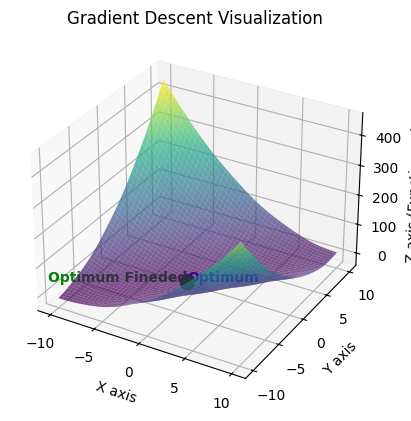

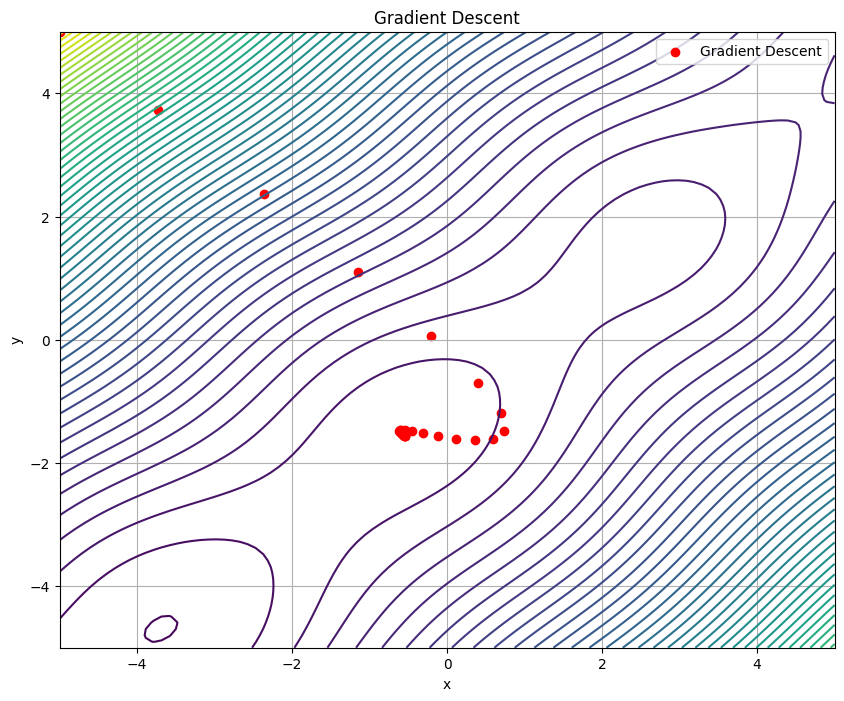

In [28]:
ex = GradientFind(f='sin(x + y) + (x-y)**2 -1.5*x + 2.5*y + 1', initial_params=np.array([-5,5]), 
                  treshold=0.001, learning_rate = 0.1, animation_interval_ms=10, grad_approximetely=False,
                  metod='adaptive', lr_dynamic=True)
ex.find()
ex.plot_animation()
ex.plot_simple()

# Функция МакКормика
(градиент с помощью sympy)

Кол-во шагов = 179
min -> x = -0.51262, y = -1.50554
C scipy ~= Аналитическое решение -> [-0.54719765 -1.54719756]
Ошибка = 0.0026020079315243194


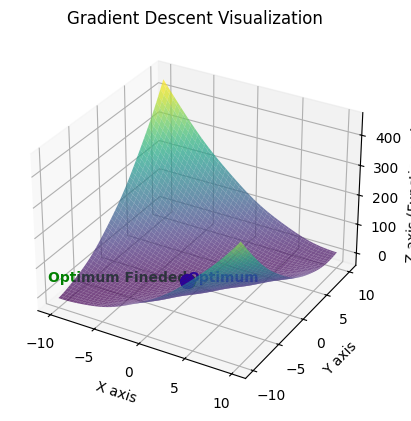

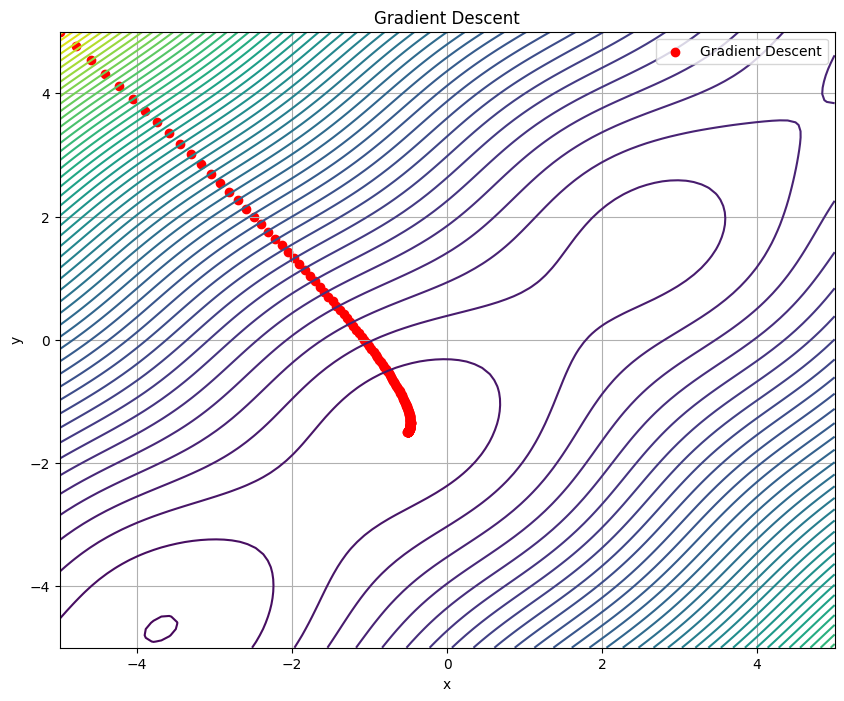

In [18]:
ex = GradientFind(f='sin(x + y) + (x-y)**2 -1.5*x + 2.5*y + 1', initial_params=np.array([-5,5]), 
                  treshold=0.001, learning_rate = 0.01, animation_interval_ms=10, grad_approximetely=False)
ex.find()
ex.plot_animation()
ex.plot_simple()

# Функция МакКормика
(численная апроксимация градиента)

Кол-во шагов = 179
min -> x = -0.51255, y = -1.50547
C scipy ~= Аналитическое решение -> [-0.54719766 -1.54719756]
Ошибка = 0.0026122372558132767


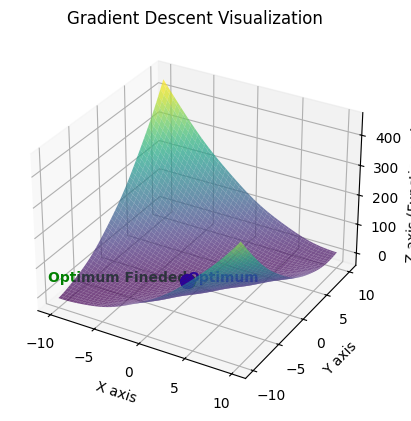

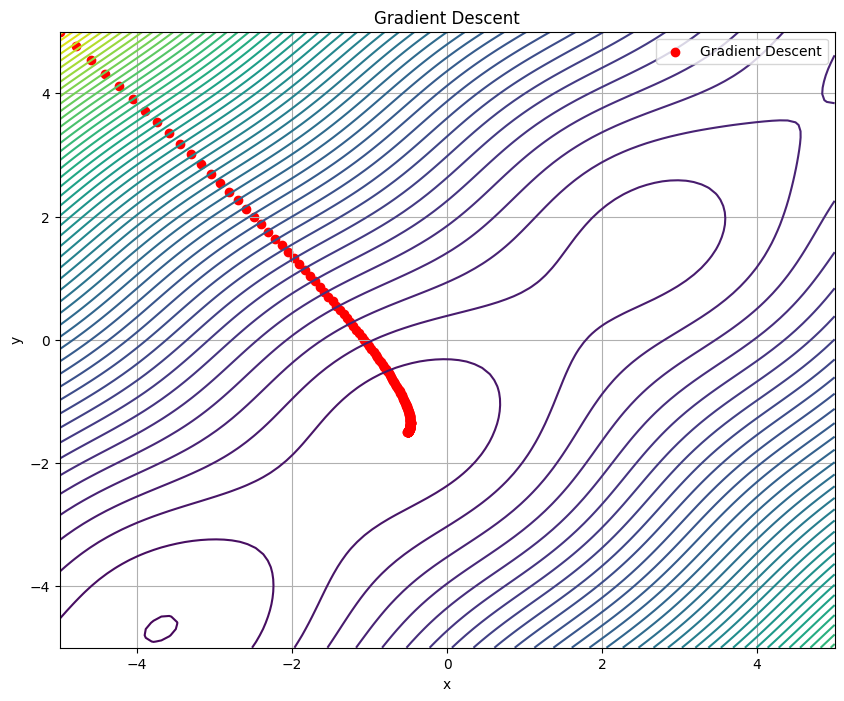

In [19]:
ex = GradientFind(f='sin(x + y) + (x-y)**2 -1.5*x + 2.5*y + 1', initial_params=np.array([-5,5]), 
                  treshold=0.001, learning_rate = 0.01, animation_interval_ms=10, grad_approximetely=True)
ex.find()
ex.plot_animation()
ex.plot_simple()

# Функция Химмельблау

Кол-во шагов = 10
min -> x = -2.80461, y = 3.13127
C scipy ~= Аналитическое решение -> [-2.80511809  3.13131251]
Ошибка = 8.400751569728552e-06


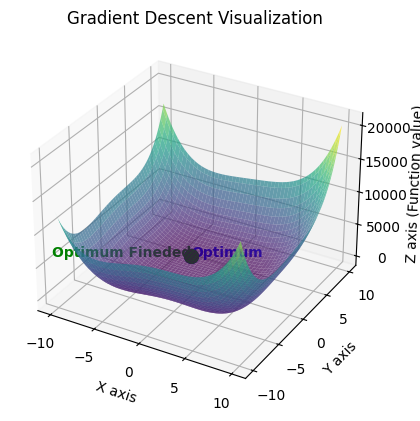

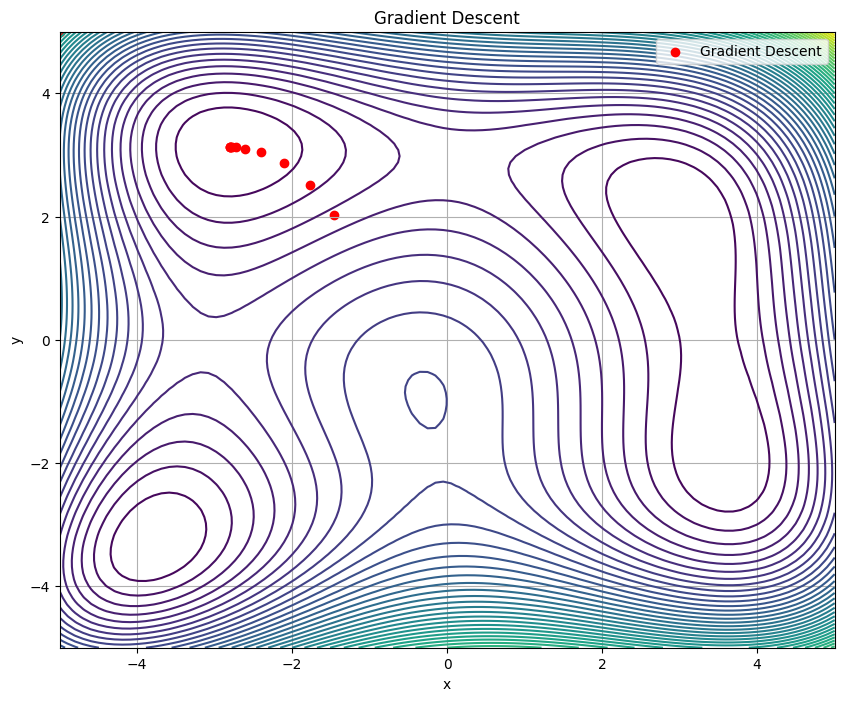

In [20]:
ex = GradientFind(f='(x**2 + y - 11)**2 + (x + y**2 - 7)**2', initial_params=np.array([-5,5]), treshold=0.001, learning_rate = 0.01, animation_interval_ms=10)
ex.find()
ex.plot_animation()
ex.plot_simple()

# Функция Матьяса

моментная модификация

Кол-во шагов = 243
min -> x = -0.03324, y = 0.03324
C scipy ~= Аналитическое решение -> [-3.87051122e-09 -3.88565960e-09]
Ошибка = 0.0011046555904822774


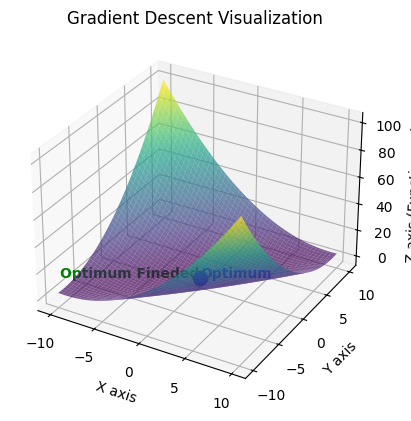

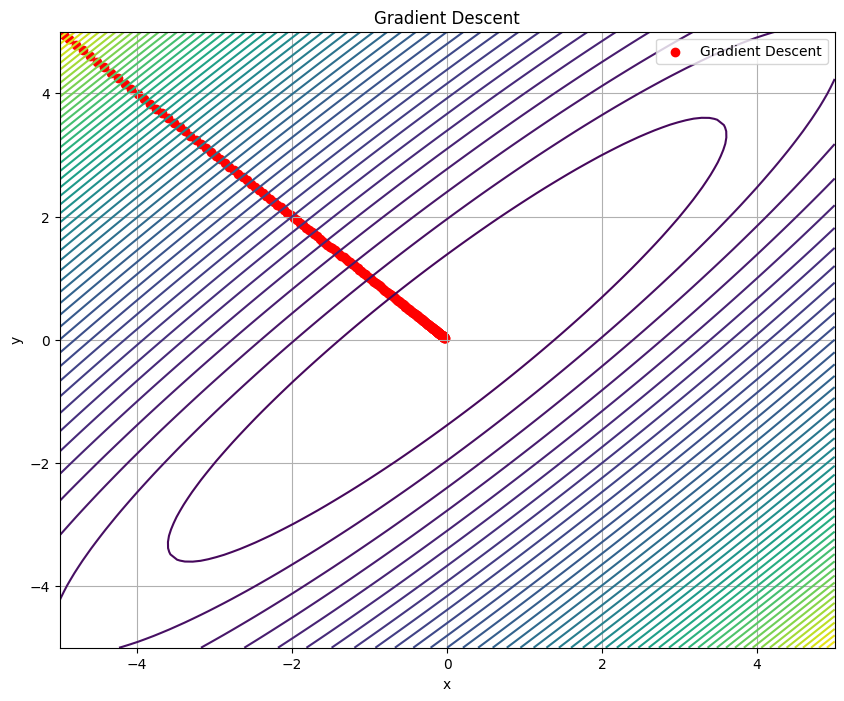

In [7]:
ex = GradientFind(f='0.26*(x**2+y**2) - 0.48*x*y', 
                  initial_params=np.array([-5,5]),
                    treshold=0.001, learning_rate = 0.01, metod='momentum', animation_interval_ms=10)
ex.find()
ex.plot_animation()
ex.plot_simple()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.widgets import Slider

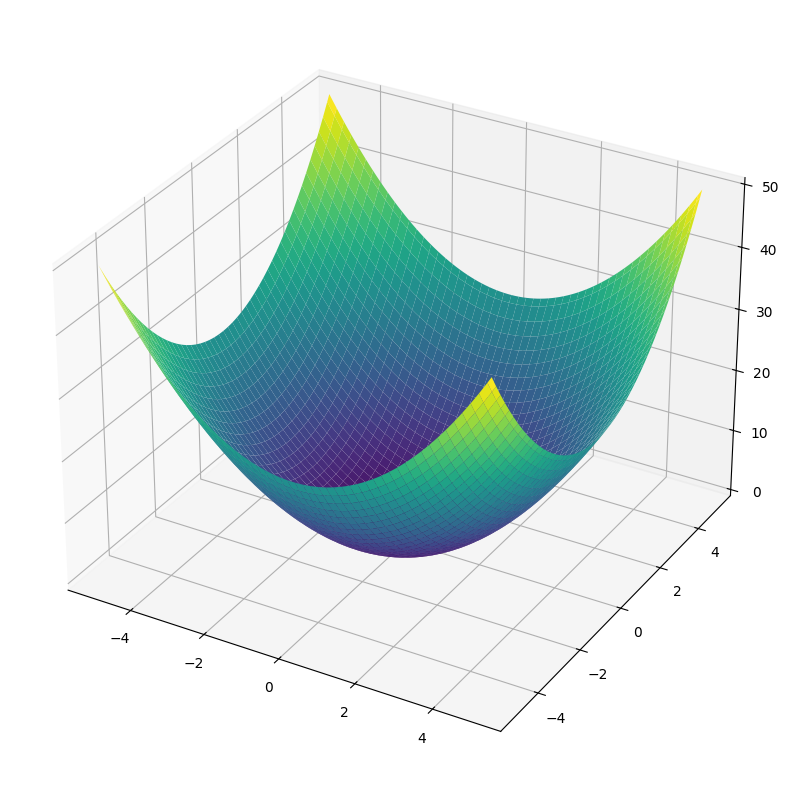

In [2]:
fig = plt.figure(figsize=(25, 10))

# Определяем функцию, которую хотим визуализировать
def func(x, y):
  return (x**2 + y**2)

# Создаем сетку для графика
x = np.linspace(-5, 5, 100)
y = np.linspace(-5, 5, 100)
X, Y = np.meshgrid(x, y)
Z = func(X, Y)

# Создаем 3D-график

ax = fig.add_subplot(111, projection='3d')
plot = ax.plot_surface(X, Y, Z, cmap='viridis')

# Отображаем график
plt.show()
